<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/Time_Series_Forecasting_with_RNN%2C_GRU%2C_and_LSTM_Models_A_Comparative_Analysis_on_AAPL_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Title: Time Series Forecasting with RNN, GRU, and LSTM Models: A Comparative Analysis on AAPL Stock Price

##Summary
Time series forecasting is a powerful technique used to predict future values based on historical data. This analysis explores three types of recurrent neural networks (RNNs)—Simple RNN, GRU (Gated Recurrent Unit), and LSTM (Long Short-Term Memory) with an attention mechanism—to forecast the closing stock price of Apple Inc. (AAPL). The objective was to evaluate and compare their predictive performance. The LSTM model was enhanced with an attention mechanism, allowing it to focus on relevant parts of the input sequence, potentially improving prediction accuracy.

The models were assessed using key performance metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²). Results showed that the GRU model performed the best, achieving the lowest MSE (39.51) and highest R² (0.94), demonstrating strong predictive accuracy. The RNN model exhibited moderate performance (MSE: 490.78, R²: 0.26), while the LSTM with Attention model had the weakest results (MSE: 723.37, R²: -0.09), indicating high error and poor predictive capability. These results contradict the common belief that LSTM with attention mechanisms is typically the preferred method for stock price prediction. Link is here.

##Importing Libraries for Stock Prediction Modeling
This script imports libraries for data manipulation, visualization, and modeling, including numpy, pandas, matplotlib, and yfinance for stock data analysis. It also prepares for machine learning model development using Keras' GRU, RNN, LSTM layers, and attention mechanisms, with performance evaluation through metrics like MSE, MAE, and R².

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, SimpleRNN, Dense, Input, Dropout, LSTM, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
import tensorflow as tf
import os

##Data Preparation and Preprocessing for Forecasting

In this step, the script involved downloading AAPL stock data from Yahoo Finance, checking for missing values, and filling any gaps with forward fill. It scaled the closing price data using MinMaxScaler, created sequences for time series forecasting by using the last 60 days of data to predict the next day's closing price, and split the data into training and testing sets. Finally, it reshaped the input data to ensure compatibility with machine learning models.

In [8]:

# Step 1: Data Cleaning and Feature Engineering

# Download AAPL stock data
print("Downloading AAPL stock data...")
aapl_data = yf.download('AAPL', start='2020-01-01', end='2025-01-01')

# Check for missing values
print("\nChecking for missing values...")
print(aapl_data.isnull().sum())

# Fill missing values (if any) using forward fill
print("\nFilling missing values (if any) using forward fill...")
aapl_data.ffill(inplace=True)

# Prepare data for scaling
print("\nScaling the data using MinMaxScaler...")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_data['Close'].values.reshape(-1, 1))

# Create sequences for 1-day forecasting
print("\nCreating sequences for time series forecasting...")
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Use the last 60 days to predict the next day's closing price
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
print("\nSplitting the data into training and testing sets...")
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape data for model input
print("\nReshaping data for model input...")
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


[*********************100%***********************]  1 of 1 completed


Checking for missing values...
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Filling missing values (if any) using forward fill...

Scaling the data using MinMaxScaler...

Creating sequences for time series forecasting...

Splitting the data into training and testing sets...

Reshaping data for model input...


##Define Attention Layer

This script defines a custom Attention layer, which is crucial for enhancing the model's ability to focus on specific time steps in the input data. The Attention class inherits from the Keras Layer class and includes two main components: the weight matrix W and the bias b. These components are initialized and then used in the call method to calculate the attention scores, which are applied to the input data. The attention scores are computed by first applying a tanh activation function to the weighted input, followed by a softmax operation to normalize the scores. Finally, the attention scores are used to scale the input data, and a weighted sum of the inputs is returned, which allows the model to focus on the most relevant parts of the data when making predictions.

In [14]:

# Step 2: Define Attention Layer
print("\nDefining the Attention Layer...")
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        at = tf.nn.softmax(et, axis=1)
        output = x * at
        return tf.reduce_sum(output, axis=1)


Defining the Attention Layer...


##Build Models with Dropout and Hyperparameter Tuning

In this step, three different models are built: a GRU model, an RNN model, and an LSTM model with attention. Each model is designed with dropout layers to prevent overfitting, and they all predict a single value. The GRU and RNN models are sequential, with two layers of the respective type followed by a dropout layer, a dense layer, and a final output layer. The LSTM model incorporates an attention mechanism to focus on important time steps in the sequence. All models are compiled using the Adam optimizer and mean squared error as the loss function.

In [10]:
# Step 3: Build Models with Dropout and Hyperparameter Tuning

# Build GRU Model
print("\nBuilding the GRU model...")
def build_gru():
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))  # Add dropout to reduce overfitting
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))  # Add dropout to reduce overfitting
    model.add(Dense(25))
    model.add(Dense(1))  # Predict 1 value
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build RNN Model
print("\nBuilding the RNN model...")
def build_rnn():
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))  # Add dropout to reduce overfitting
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dropout(0.2))  # Add dropout to reduce overfitting
    model.add(Dense(25))
    model.add(Dense(1))  # Predict 1 value
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build LSTM with Attention Model
print("\nBuilding the LSTM with Attention model...")
def build_lstm_attention():
    inputs = Input(shape=(X_train.shape[1], 1))
    lstm_out = LSTM(50, return_sequences=True)(inputs)
    lstm_out = Dropout(0.2)(lstm_out)  # Add dropout to reduce overfitting
    attention_out = Attention()(lstm_out)
    outputs = Dense(1)(attention_out)  # Predict 1 value
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



Building the GRU model...

Building the RNN model...

Building the LSTM with Attention model...


#Train and Evaluate Models with Early Stopping

In this step, the GRU, RNN, and LSTM with Attention models are trained and evaluated using early stopping to prevent overfitting. The models are trained for up to 50 epochs, with early stopping monitoring validation loss and restoring the best weights. After training, predictions are made on the test set, and the models were used to recursively forecast the next 10 days' stock prices. The performance was evaluated using metrics such as mean squared error (MSE), mean absolute error (MAE), and R². The results, including predictions and forecasts, are stored for comparison.

In [11]:
# Step 4: Train and Evaluate Models with Early Stopping

print("\nTraining and evaluating models...")
models = {
    "GRU": build_gru(),
    "RNN": build_rnn(),
    "LSTM with Attention": build_lstm_attention()
}

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=50,  # Increased epochs for early stopping
        validation_split=0.2,  # Use 20% of training data for validation
        callbacks=[early_stopping],
        verbose=0
    )

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)  # Inverse transform to get actual values

    # Initialize the forecast with the last sequence in the test set
    last_sequence = X_test[-1]
    forecast = []

    # Recursively predict the next 10 days
    for _ in range(10):
        next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
        forecast.append(next_pred[0][0])
        last_sequence = np.append(last_sequence[1:], next_pred)  # Update the sequence with the new prediction

    # Inverse transform the forecasted values
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

    # Calculate metrics
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
    mse = mean_squared_error(y_test_orig, y_pred)
    mae = mean_absolute_error(y_test_orig, y_pred)
    r2 = r2_score(y_test_orig, y_pred)

    # Store results
    results[name] = {
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "Predictions": y_pred,
        "Forecast": forecast
    }



Training and evaluating models...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training GRU...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Training RNN...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Training LSTM with Attention...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━

#Visualization

This step visualizes the actual stock prices alongside the model predictions and forecasts on a single graph. The test set's actual closing prices are plotted as a black line, while predictions from the GRU, RNN, and LSTM with Attention models are displayed in different colors. A dashed line represents the 10-day forecast for each model, with a vertical marker indicating the transition from historical data to forecasting. A shaded region highlights the forecast period, and gridlines and a legend enhance readability. The graph provides a clear comparison of model performance in predicting future stock prices.


Plotting the results...


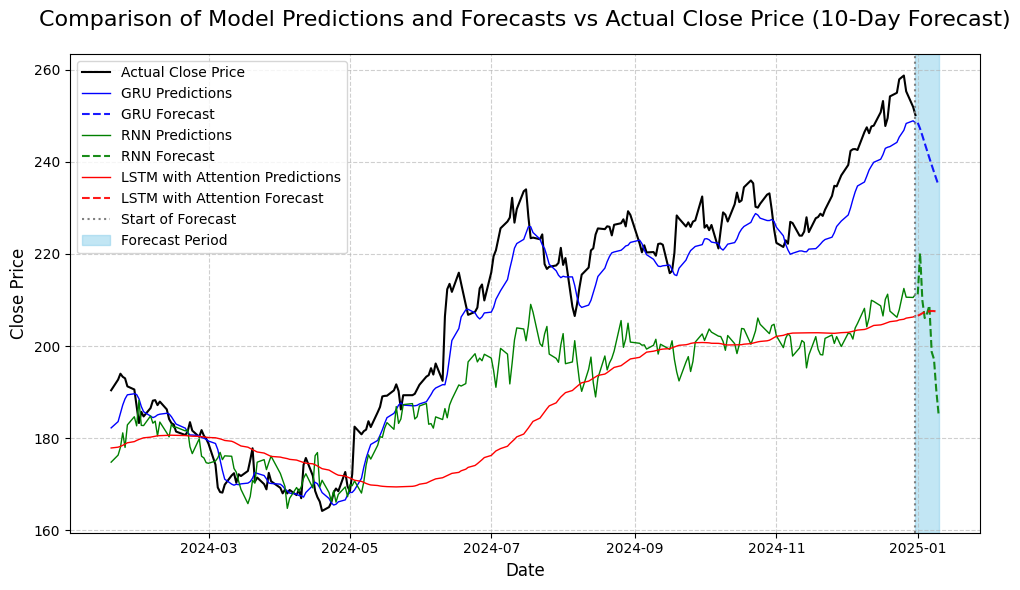

In [12]:
# Step 5: Visualization

# Plot Results on One Graph
print("\nPlotting the results...")
plt.figure(figsize=(10, 6))  # Reduced figure size

# Adjust the date index to match the length of the test set
date_index = aapl_data.index[-len(y_test):]

# Plot actual values (thinner line)
plt.plot(date_index, scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Close Price', color='black', linewidth=1.5)

# Define colors for each model
colors = ['blue', 'green', 'red']

# Plot predictions and forecasts for each model
for (name, result), color in zip(results.items(), colors):
    # Plot historical predictions (continuous line, thinner)
    plt.plot(date_index, result["Predictions"], label=f'{name} Predictions', color=color, linestyle='-', linewidth=1)

    # Plot forecasted values (broken/dashed line, thinner)
    forecast_dates = pd.date_range(start=date_index[-1], periods=11)[1:]  # Start from the next day
    plt.plot(forecast_dates, result["Forecast"], label=f'{name} Forecast', color=color, linestyle='--', linewidth=1.5, alpha=0.9)

# Add a vertical line to mark the start of the forecast period (thinner line)
plt.axvline(x=date_index[-1], color='gray', linestyle=':', linewidth=1.5, label='Start of Forecast')

# Add a shaded region for the forecast period with a more visible pink background
plt.axvspan(date_index[-1], forecast_dates[-1], color='skyblue', alpha=0.5, label='Forecast Period')  # Increased alpha for visibility

# Add title and labels
plt.title("Comparison of Model Predictions and Forecasts vs Actual Close Price (10-Day Forecast)", fontsize=16, pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend inside the plot
plt.legend(fontsize=10, loc='upper left')

# Improve layout
plt.tight_layout()
plt.show()

#Performance Metrics
This step presents a performance comparison of the models using key metrics—Mean Squared Error (MSE), Mean Absolute Error (MAE), and R²—sorted in ascending order of MSE to highlight the best-performing model. Additionally, a table displaying the forecasted closing prices for the next 10 days is generated, showing predictions from the GRU, RNN, and LSTM with Attention models. These tables provide a structured overview of model accuracy and future stock price projections

The performance metrics, sorted by Mean Squared Error (MSE), indicate that the GRU model outperformed the others with the lowest MSE (39.51), lowest Mean Absolute Error (MAE) (5.07), and the highest R² score (0.94), suggesting a strong predictive capability. The RNN model performed moderately with a significantly higher MSE (490.78), MAE (18.05), and a lower R² score (0.26), indicating reduced accuracy. The LSTM with Attention model had the weakest performance, with the highest MSE (723.37), MAE (22.86), and a negative R² score (-0.09), implying poor predictive power and high error.

In [16]:
# Step 6: Performance Metrics

# Create a DataFrame for metrics
metrics_table = pd.DataFrame.from_dict(results, orient='index')
metrics_table = metrics_table[['MSE', 'MAE', 'R²']]

# Sort the table by MSE (ascending order, best to worst)
metrics_table = metrics_table.sort_values(by='MSE')

# Print the metrics table
print("\nPerformance Metrics (Sorted by MSE):")
print(metrics_table)

# Step 7: Display Forecasted Prices Table (at the end)
print("\nForecasted Close Prices for the Next 10 Days:")
forecast_table = pd.DataFrame({
    "Day": range(1, 11),
    "GRU": results["GRU"]["Forecast"].flatten(),
    "RNN": results["RNN"]["Forecast"].flatten(),
    "LSTM with Attention": results["LSTM with Attention"]["Forecast"].flatten()
})
print(forecast_table)


Performance Metrics (Sorted by MSE):
                            MSE        MAE        R²
GRU                   39.509533   5.073692  0.940338
RNN                  490.775702  18.050094  0.258895
LSTM with Attention  723.367252  22.863326 -0.092334

Forecasted Close Prices for the Next 10 Days:
   Day         GRU         RNN  LSTM with Attention
0    1  248.483932  211.253098           206.593323
1    2  247.200668  220.198624           206.847961
2    3  245.656143  209.872620           207.144180
3    4  244.049332  206.094849           207.353790
4    5  242.445282  207.101395           207.476013
5    6  240.864792  208.831512           207.564224
6    7  239.314102  198.751602           207.632065
7    8  237.794830  197.166962           207.615143
8    9  236.306976  190.365921           207.531921
9   10  234.849960  185.116776           207.444473
